# Choose whether to ignore warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# Load data

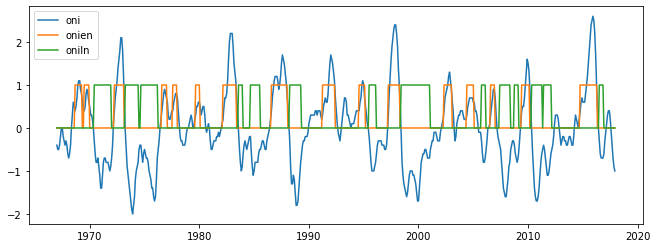

In [2]:
%run wcpfc_load_and_calc.ipynb

# Extra things to load

In [20]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import dask
import matplotlib.ticker as mticker
import scipy.stats as stats

In [4]:
lon = wf['lon']
lat = wf['lat']

# Load WOD18 data

In [5]:
# Load o2, temp, sal from WOD18 nc files (already on good grid)
# -->Get SST, O2100, SSS
# -->Compute THD, TCD, O2100INT, T100INT

In [6]:
ncfile = dpath + 'WOD18/o2_195501-201807_5deg.nc'
o2 = xr.open_dataset(ncfile)
ncfile = dpath + 'WOD18/sal_195501-201807_5deg.nc'
sal = xr.open_dataset(ncfile)
ncfile = dpath + 'WOD18/temp_195501-201807_5deg.nc'
temp = xr.open_dataset(ncfile)

### Correct the time axis

In [7]:
# - Time goes from Jan 1955 - Jul 2018 --> 763 months
begdatewod = datetime.date(year = 1955, month = 1, day = 1)
enddatewod = datetime.date(year = 2018, month = 7, day = 1)
timemowod = pd.date_range(begdatewod, enddatewod, freq='MS')

In [8]:
o2['time'] = timemowod
sal['time'] = timemowod
temp['time'] = timemowod

In [9]:
sst = temp['Temp'].isel(depth=0)
o2100 = o2['O2'].sel(depth=100)
sss = sal['Sal'].isel(depth=0)

### Change from -180-180 to 0-360 lon

In [10]:
# https://github.com/pydata/xarray/issues/577 - wrap 0 to 360
# https://github.com/pydata/xarray/issues/1875 - roll
sst['lon'] = np.mod(sst['lon'], 360)
sst = sst.reindex({'lon': np.sort(sst['lon'])}) # or: sst = sst.roll(lon=36)
o2100['lon'] = np.mod(o2100['lon'], 360)
o2100 = o2100.reindex({'lon': np.sort(o2100['lon'])}) # or: o2100 = o2100.roll(lon=36)
sss['lon'] = np.mod(sss['lon'], 360)
sss = sss.reindex({'lon': np.sort(sss['lon'])}) # or: sss = sss.roll(lon=36)

### Rename

In [11]:
sst.name = 'sst'
o2100.name = 'o2100'
sss.name = 'sss'

# Load chl data

In [12]:
ncfile = dpath + 'chl/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_5degWCPFCgrid_GEO_PML_OCx-199709-201812-fv4.0.nc'
chl = xr.open_dataset(ncfile)

### Correct the time axis

In [13]:
# - Time goes from Sep 1997 - Dec 2018 --> 256 months
begdatechl = datetime.date(year = 1997, month = 9, day = 1)
enddatechl = datetime.date(year = 2018, month = 12, day = 1)
timemochl = pd.date_range(begdatechl, enddatechl, freq='MS')
chl['TIME'] = timemochl

### Rename

In [14]:
logchl = np.log10(chl['CHLA'])
logchl = logchl.rename({'LON':'lon', 'LAT':'lat', 'TIME':'time'})
logchl.name = 'logchl'

# Load MLD data

In [15]:
ncfile = dpath + 'ecco/MXLDEPTH.0001.WCPFC5deggrid.nc'
MLD = xr.open_dataset(ncfile)
mld = MLD['MLD']

### Correct the time axis

In [16]:
# - Time goes from Jan 1992 - Dec 2011 --> 240 months
begdatemld = datetime.date(year = 1992, month = 1, day = 1)
enddatemld = datetime.date(year = 2011, month = 12, day = 1)
timemomld = pd.date_range(begdatemld, enddatemld, freq='MS')
mld['TIME'] = timemomld

### Rename

In [17]:
mld = mld.rename({'LON':'lon', 'LAT':'lat', 'TIME':'time'})
mld.name = 'mld'

# Load SSHA data

In [67]:
combinedssha = xr.open_mfdataset(dpath + 'aviso/msla/*.nc', concat_dim="time",
                  data_vars='minimal', coords='minimal', compat='override')
# The above command concatenates variables along the "time" dimension,
# but only those that already contain the "time" dimension (data_vars='minimal', coords='minimal').
# Variables that lack the "time" dimension are taken from the first dataset (compat='override').
ssha = 100*combinedssha['SSHA']

### Correct the time axis

In [68]:
# - Time goes from Jan 1993 - Dec 2018 --> 312 months
begdatessha = datetime.date(year = 1993, month = 1, day = 1)
enddatessha = datetime.date(year = 2018, month = 12, day = 1)
timemossha = pd.date_range(begdatessha, enddatessha, freq='MS')
ssha['TIME'] = timemossha

### Rename

In [69]:
ssha = ssha.rename({'LON':'lon', 'LAT':'lat', 'TIME':'time'})
ssha.name = 'ssha'

# ?Load wind speed or Lyapunov data

In [35]:
# (need to regrid to WCPFC grid OR use already matlab regridded files)

# Question 3abc from 9/19/19 in written lab notebook

In [36]:
def quotient_analysis(dfqa,binedges):
    # IV for indy var, DV for dep var
    dfqa['IV_bin']=pd.cut(dfqa['IV'],binedges)
    ivcounts=dfqa.groupby('IV_bin')['IV'].count()
    dvcounts=dfqa.groupby('IV_bin')['DV'].sum()
    ivfreq = ivcounts*100/ivcounts.sum()
    dvfreq = dvcounts*100/dvcounts.sum()
    dvquot = dvfreq/ivfreq
    return ivcounts, dvcounts, dvquot

In [37]:
def qafull(ivfull,dvfull,ivname,dvname,nbins,nruns):
    iv = ivfull.where(dvfull.notnull())
    dv = dvfull.where(ivfull.notnull())    
    
    ivminf = np.floor(10*iv.min())/10
    ivmaxc = np.ceil(10*iv.max())/10
    binedges = np.linspace(ivminf,ivmaxc,nbins+1)
            
    fig,axes = plt.subplots(figsize=(7,5),nrows=2,ncols=2)
    ivfull.plot.hist(ax=axes[0][0],bins=20); axes[0][0].set_title('IV - all values');
    iv.plot.hist(ax=axes[0][1],bins=20); axes[0][1].set_title('IV - assoc w/ DV values');
    dvfull.plot.hist(ax=axes[1][0],bins=20); axes[1][0].set_title('DV - all values');
    dv.plot.hist(ax=axes[1][1],bins=20); axes[1][1].set_title('DV - assoc w/ IV values');
    fig.tight_layout()
    
    dsqanow = xr.merge([iv, dv])
    dfqa = dsqanow.to_dataframe()
    dfqa.rename(columns={ivname: 'IV', dvname: 'DV'}, inplace=True)
    dfqa.reset_index(inplace=True)
    dfqa = dfqa.dropna(subset=['IV','DV'], how='any')

    ivcounts, dvcounts, dvquot = quotient_analysis(dfqa,binedges)

    # Bernal et al. 2007: replace=FALSE in the code, but in the paper it says replace=TRUE
    # --> I think I'll go w/ what the paper says?
    dfsimreplaceF = pd.DataFrame(); dfsimreplaceT = pd.DataFrame()
    for i in range(nruns):
        dfsimreplaceF=pd.concat([dfsimreplaceF,dfqa['DV'].sample(
            n=len(dfqa['DV']),replace=False).reset_index(
            drop=True)], axis=1).rename(columns={'DV':i})
        dfsimreplaceT=pd.concat([dfsimreplaceT,dfqa['DV'].sample(
            n=len(dfqa['DV']),replace=True).reset_index(
            drop=True)], axis=1).rename(columns={'DV':i})

    dfsimreplaceF = dfsimreplaceF.assign(IV=dfqa['IV'].values)
    dfsimreplaceT = dfsimreplaceT.assign(IV=dfqa['IV'].values)

    quotsimreplaceF = pd.DataFrame(); quotsimreplaceT = pd.DataFrame()
    for i in range(nruns):
        _,_,quotsimreplaceFtemp = quotient_analysis(
            dfsimreplaceF[[i,'IV']].rename(columns={i:'DV'}),binedges)
        quotsimreplaceF = pd.concat([quotsimreplaceF,quotsimreplaceFtemp], axis=1)
        _,_,quotsimreplaceTtemp = quotient_analysis(
            dfsimreplaceT[[i,'IV']].rename(columns={i:'DV'}),binedges)
        quotsimreplaceT = pd.concat([quotsimreplaceT,quotsimreplaceTtemp], axis=1)

    qlimsreplaceT = quotsimreplaceT.quantile([0.025, 0.975], axis=1)
    qlimsreplaceF = quotsimreplaceF.quantile([0.025, 0.975], axis=1)
    bincenters = (binedges[1:] + binedges[:-1])/2

    return dfqa['IV'], binedges, bincenters, ivcounts, dvcounts, dvquot, qlimsreplaceT, qlimsreplaceF

### SKJ CPUE x SST

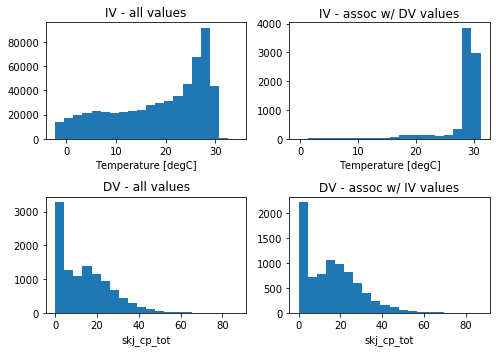

In [38]:
ivfull = sst; dvfull = skj_cp_tot
ivname = 'sst'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
#binedges = np.arange(-0.3,31.2+0.3,0.5) # sstnow.max() = 31.15, sstnow.min() = -0.28
iv_sstskjcp, binedges_sstskjcp, bincenters_sstskjcp, ivcounts_sstskjcp, \
    dvcounts_sstskjcp, dvquot_sstskjcp, qlimsreplaceT_sstskjcp, qlimsreplaceF_sstskjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE x O2100

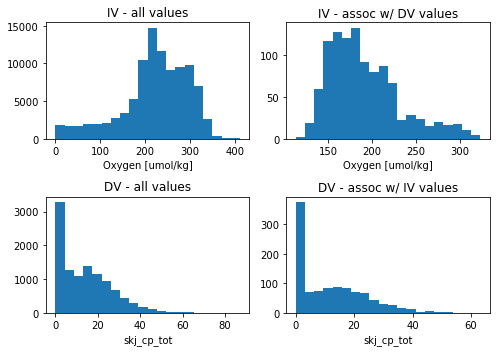

In [39]:
ivfull = o2100; dvfull = skj_cp_tot
ivname = 'o2100'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
iv_o2100skjcp, binedges_o2100skjcp, bincenters_o2100skjcp, ivcounts_o2100skjcp, \
    dvcounts_o2100skjcp, dvquot_o2100skjcp, qlimsreplaceT_o2100skjcp, qlimsreplaceF_o2100skjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE x SSS 

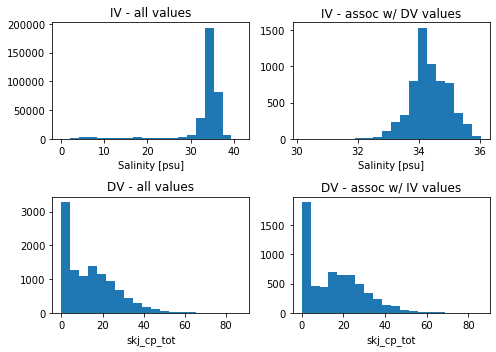

In [40]:
ivfull = sss; dvfull = skj_cp_tot
ivname = 'sss'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
iv_sssskjcp, binedges_sssskjcp, bincenters_sssskjcp, ivcounts_sssskjcp, \
    dvcounts_sssskjcp, dvquot_sssskjcp, qlimsreplaceT_sssskjcp, qlimsreplaceF_sssskjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE x LOGCHL

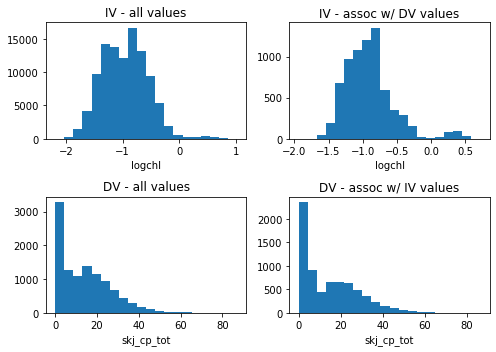

In [41]:
ivfull = logchl; dvfull = skj_cp_tot
ivname = 'logchl'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
iv_logchlskjcp, binedges_logchlskjcp, bincenters_logchlskjcp, ivcounts_logchlskjcp, \
    dvcounts_logchlskjcp, dvquot_logchlskjcp, qlimsreplaceT_logchlskjcp, qlimsreplaceF_logchlskjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE x MLD

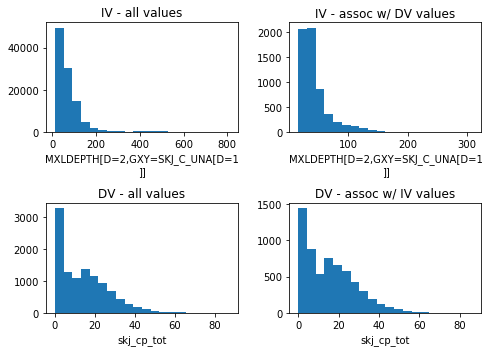

In [42]:
ivfull = mld; dvfull = skj_cp_tot
ivname = 'mld'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
iv_mldskjcp, binedges_mldskjcp, bincenters_mldskjcp, ivcounts_mldskjcp, \
    dvcounts_mldskjcp, dvquot_mldskjcp, qlimsreplaceT_mldskjcp, qlimsreplaceF_mldskjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE x SSHA

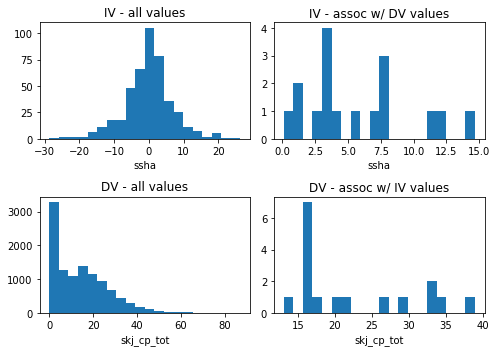

In [71]:
ivfull = ssha; dvfull = skj_cp_tot
ivname = 'ssha'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
iv_sshaskjcp, binedges_sshaskjcp, bincenters_sshaskjcp, ivcounts_sshaskjcp, \
    dvcounts_sshaskjcp, dvquot_sshaskjcp, qlimsreplaceT_sshaskjcp, qlimsreplaceF_sshaskjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE quotient analysis plot

In [72]:
ivunitsall = ['degC','umol/kg','psu','log(mg/m$^3$)','m','cm']
ivnicenamesall = ['SST','O$2_{100m}$','SSS','log(CHL)','MLD','SSHA']
dvnicenamesall = ['Skipjack CPUE','Skipjack CPUE','Skipjack CPUE',
                  'Skipjack CPUE','Skipjack CPUE','Skipjack CPUE']
ivall = [iv_sstskjcp, iv_o2100skjcp, iv_sssskjcp,
         iv_logchlskjcp, iv_mldskjcp, iv_sshaskjcp]
binedgesall = [binedges_sstskjcp, binedges_o2100skjcp, binedges_sssskjcp,
               binedges_logchlskjcp, binedges_mldskjcp, binedges_sshaskjcp]
bincentersall = [bincenters_sstskjcp, bincenters_o2100skjcp, bincenters_sssskjcp,
                 bincenters_logchlskjcp, bincenters_mldskjcp, bincenters_sshaskjcp]
ivcountsall = [ivcounts_sstskjcp, ivcounts_o2100skjcp, ivcounts_sssskjcp,
               ivcounts_logchlskjcp, ivcounts_mldskjcp, ivcounts_sshaskjcp]
dvcountsall = [dvcounts_sstskjcp, dvcounts_o2100skjcp, dvcounts_sssskjcp,
               dvcounts_logchlskjcp, dvcounts_mldskjcp, dvcounts_sshaskjcp]
dvquotall = [dvquot_sstskjcp, dvquot_o2100skjcp, dvquot_sssskjcp,
             dvquot_logchlskjcp, dvquot_mldskjcp, dvquot_sshaskjcp]
qlimsreplaceTall = [qlimsreplaceT_sstskjcp, qlimsreplaceT_o2100skjcp, qlimsreplaceT_sssskjcp,
                    qlimsreplaceT_logchlskjcp, qlimsreplaceT_mldskjcp, qlimsreplaceT_sshaskjcp]
qlimsreplaceFall = [qlimsreplaceF_sstskjcp, qlimsreplaceF_o2100skjcp, qlimsreplaceF_sssskjcp,
                    qlimsreplaceF_logchlskjcp, qlimsreplaceF_mldskjcp, qlimsreplaceF_sshaskjcp]

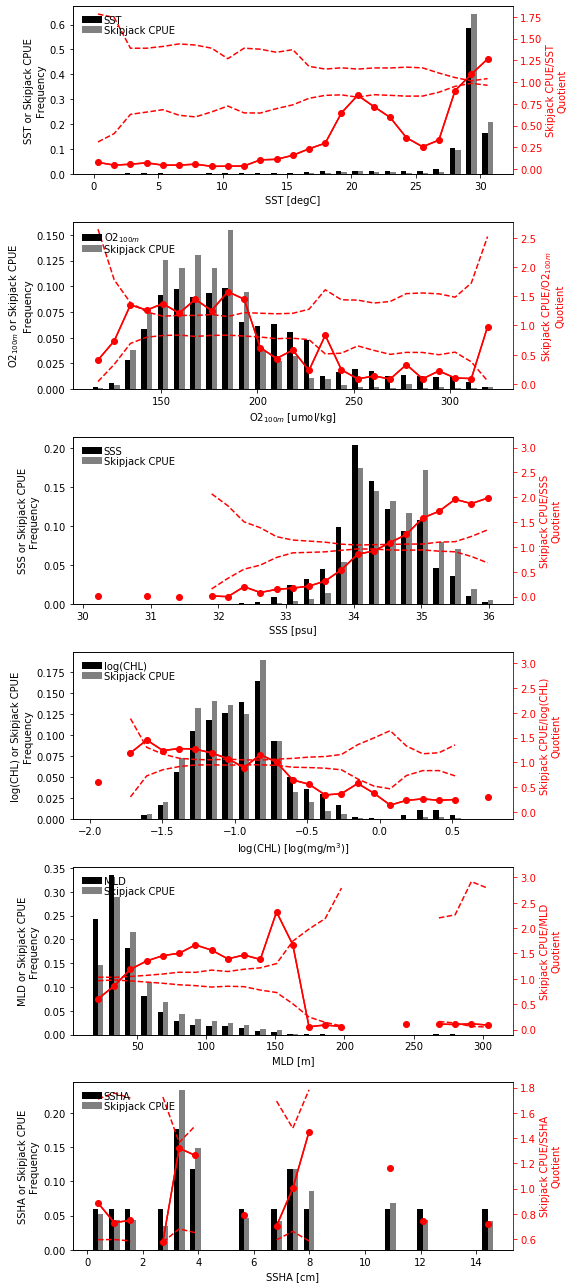

In [73]:
plotbarorhist='bar'; plotlegend=1;
plotqlimsreplaceT=1; plotqlimsreplaceF=0
nrows=6; ncols=1
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,18))
isp = 0 # subplot index
for yax in range(0,nrows):
    for xax in range(0,ncols):
        ivunits = ivunitsall[isp]
        ivnicename = ivnicenamesall[isp]; dvnicename = dvnicenamesall[isp]
        iv = ivall[isp]
        binedges = binedgesall[isp]; bincenters = bincentersall[isp]
        ivcounts = ivcountsall[isp]; dvcounts = dvcountsall[isp]
        dvquot = dvquotall[isp]
        qlimsreplaceT = qlimsreplaceTall[isp]; qlimsreplaceF = qlimsreplaceFall[isp]
        if ncols>1 and nrows>1:
            ax = axes[yax][xax]
        elif ncols==1 and nrows>1:
            ax = axes[yax] 
        elif ncols>1 and nrows==1:
            ax = axes[xax] 
        exec(open("plot_qa.py").read())
        isp = isp+1
fig.tight_layout()
fig.savefig(figpath + 'question3b_skjcpue_quotientanalysis.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### BET CPUE x SST

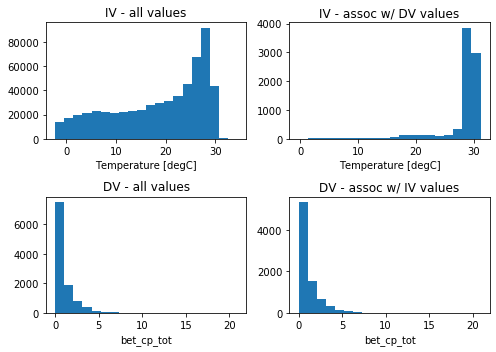

In [46]:
ivfull = sst; dvfull = bet_cp_tot
ivname = 'sst'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_sstbetcp, binedges_sstbetcp, bincenters_sstbetcp, ivcounts_sstbetcp, \
    dvcounts_sstbetcp, dvquot_sstbetcp, qlimsreplaceT_sstbetcp, qlimsreplaceF_sstbetcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE x O2100

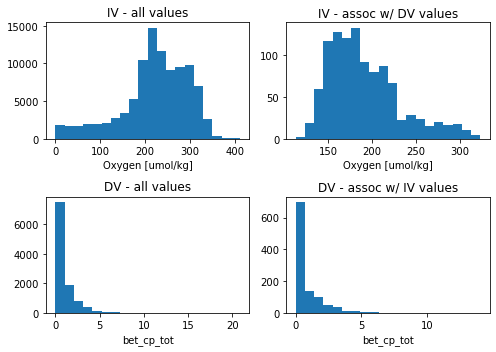

In [47]:
ivfull = o2100; dvfull = bet_cp_tot
ivname = 'o2100'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_o2100betcp, binedges_o2100betcp, bincenters_o2100betcp, ivcounts_o2100betcp, \
    dvcounts_o2100betcp, dvquot_o2100betcp, qlimsreplaceT_o2100betcp, qlimsreplaceF_o2100betcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE x SSS 

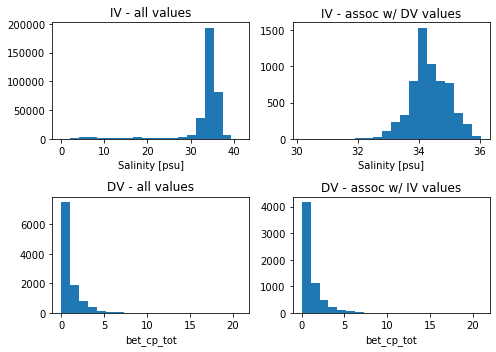

In [48]:
ivfull = sss; dvfull = bet_cp_tot
ivname = 'sss'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_sssbetcp, binedges_sssbetcp, bincenters_sssbetcp, ivcounts_sssbetcp, \
    dvcounts_sssbetcp, dvquot_sssbetcp, qlimsreplaceT_sssbetcp, qlimsreplaceF_sssbetcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE x LOGCHL

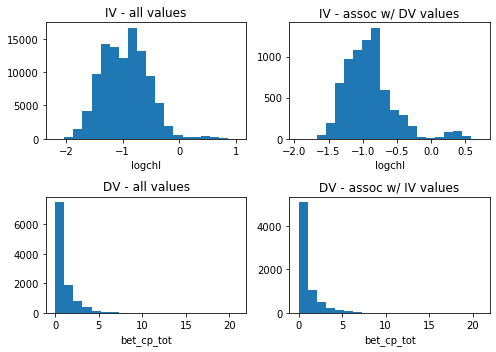

In [49]:
ivfull = logchl; dvfull = bet_cp_tot
ivname = 'logchl'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_logchlbetcp, binedges_logchlbetcp, bincenters_logchlbetcp, ivcounts_logchlbetcp, \
    dvcounts_logchlbetcp, dvquot_logchlbetcp, qlimsreplaceT_logchlbetcp, qlimsreplaceF_logchlbetcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE x MLD

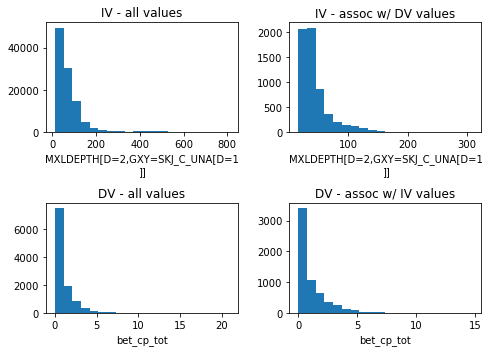

In [50]:
ivfull = mld; dvfull = bet_cp_tot
ivname = 'mld'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_mldbetcp, binedges_mldbetcp, bincenters_mldbetcp, ivcounts_mldbetcp, \
    dvcounts_mldbetcp, dvquot_mldbetcp, qlimsreplaceT_mldbetcp, qlimsreplaceF_mldbetcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE x SSHA

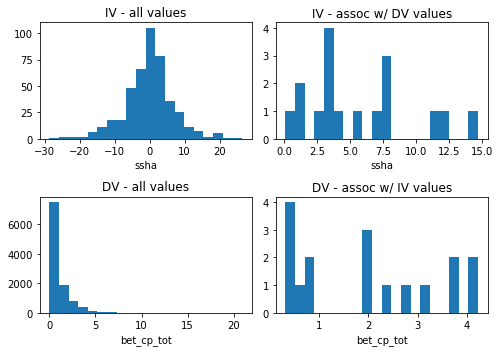

In [75]:
ivfull = ssha; dvfull = bet_cp_tot
ivname = 'ssha'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_sshabetcp, binedges_sshabetcp, bincenters_sshabetcp, ivcounts_sshabetcp, \
    dvcounts_sshabetcp, dvquot_sshabetcp, qlimsreplaceT_sshabetcp, qlimsreplaceF_sshabetcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE quotient analysis plot

In [76]:
ivunitsall = ['degC','umol/kg','psu','log(mg/m$^3$)','m','cm']
ivnicenamesall = ['SST','O$2_{100m}$','SSS','log(CHL)','MLD','SSHA']
dvnicenamesall = ['Bigeye CPUE','Bigeye CPUE','Bigeye CPUE',
                  'Bigeye CPUE','Bigeye CPUE','Bigeye CPUE']
ivall = [iv_sstbetcp, iv_o2100betcp, iv_sssbetcp,
         iv_logchlbetcp, iv_mldbetcp, iv_sshabetcp]
binedgesall = [binedges_sstbetcp, binedges_o2100betcp, binedges_sssbetcp,
               binedges_logchlbetcp, binedges_mldbetcp, binedges_sshabetcp]
bincentersall = [bincenters_sstbetcp, bincenters_o2100betcp, bincenters_sssbetcp,
                 bincenters_logchlbetcp, bincenters_mldbetcp, bincenters_sshabetcp]
ivcountsall = [ivcounts_sstbetcp, ivcounts_o2100betcp, ivcounts_sssbetcp,
               ivcounts_logchlbetcp, ivcounts_mldbetcp, ivcounts_sshabetcp]
dvcountsall = [dvcounts_sstbetcp, dvcounts_o2100betcp, dvcounts_sssbetcp,
               dvcounts_logchlbetcp, dvcounts_mldbetcp, dvcounts_sshabetcp]
dvquotall = [dvquot_sstbetcp, dvquot_o2100betcp, dvquot_sssbetcp,
             dvquot_logchlbetcp, dvquot_mldbetcp, dvquot_sshabetcp]
qlimsreplaceTall = [qlimsreplaceT_sstbetcp, qlimsreplaceT_o2100betcp, qlimsreplaceT_sssbetcp,
                    qlimsreplaceT_logchlbetcp, qlimsreplaceT_mldbetcp, qlimsreplaceT_sshabetcp]
qlimsreplaceFall = [qlimsreplaceF_sstbetcp, qlimsreplaceF_o2100betcp, qlimsreplaceF_sssbetcp,
                    qlimsreplaceF_logchlbetcp, qlimsreplaceF_mldbetcp, qlimsreplaceF_sshabetcp]

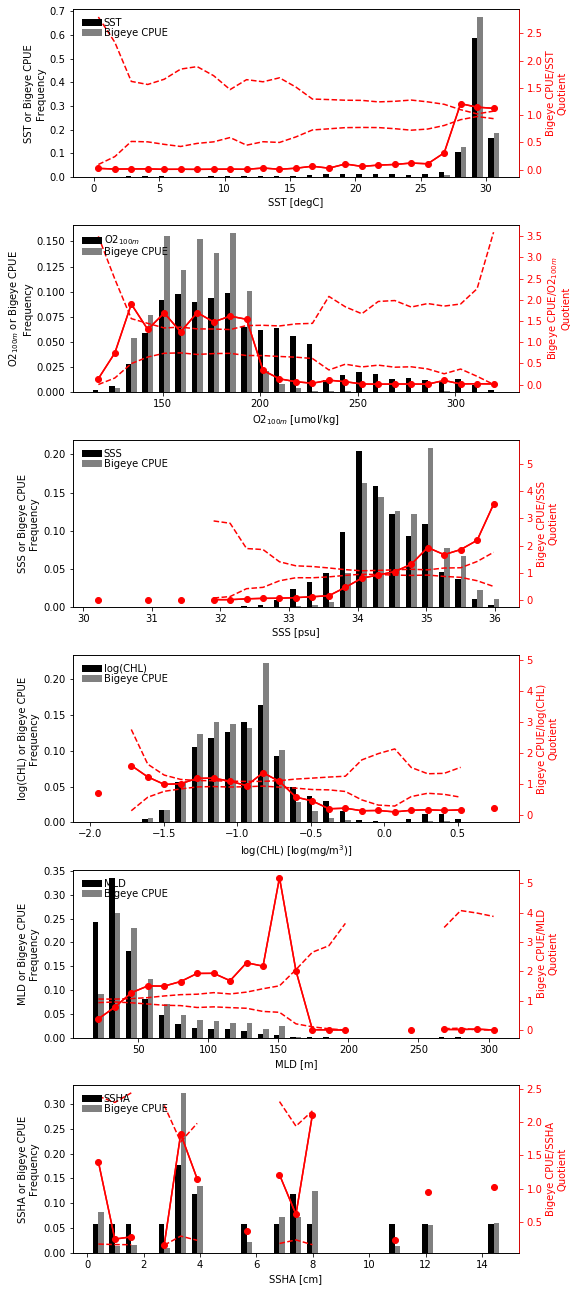

In [77]:
plotbarorhist='bar'; plotlegend=1;
plotqlimsreplaceT=1; plotqlimsreplaceF=0
nrows=6; ncols=1
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,18))
isp = 0 # subplot index
for yax in range(0,nrows):
    for xax in range(0,ncols):
        ivunits = ivunitsall[isp]
        ivnicename = ivnicenamesall[isp]; dvnicename = dvnicenamesall[isp]
        iv = ivall[isp]
        binedges = binedgesall[isp]; bincenters = bincentersall[isp]
        ivcounts = ivcountsall[isp]; dvcounts = dvcountsall[isp]
        dvquot = dvquotall[isp]
        qlimsreplaceT = qlimsreplaceTall[isp]; qlimsreplaceF = qlimsreplaceFall[isp]
        if ncols>1 and nrows>1:
            ax = axes[yax][xax]
        elif ncols==1 and nrows>1:
            ax = axes[yax] 
        elif ncols>1 and nrows==1:
            ax = axes[xax] 
        exec(open("plot_qa.py").read())
        isp = isp+1
fig.tight_layout()
fig.savefig(figpath + 'question3a_betcpue_quotientanalysis.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

In [254]:
# CONTINUE HERE WITH 3c!!!!!

In [78]:
def defineATP(row):
    if row['quot']<row['2pt5p']:
        return -1 # avoidance
    if row['quot']>=row['2pt5p'] and row['quot']<=row['97pt5p']:
        return 0 # tolerance
    if row['quot']>row['97pt5p']:
        return 1 # preference

In [92]:
len(binedges_sstbetcp[0:-1])

array([ 0.96,  2.22,  3.48,  4.74,  6.  ,  7.26,  8.52,  9.78, 11.04,
       12.3 , 13.56, 14.82, 16.08, 17.34, 18.6 , 19.86, 21.12, 22.38,
       23.64, 24.9 , 26.16, 27.42, 28.68, 29.94, 31.2 ])

In [95]:
test = pd.concat([qlimsreplaceT_sstbetcp.transpose(),dvquot_sstbetcp], axis=1)
test = test.rename(columns={0:'quot', 0.025:'2pt5p', 0.975:'97pt5p'})
test['ATP'] = test.apply(defineATP, axis=1)
test.reset_index(inplace=True)
test = pd.concat([test,pd.Series(bincenters_sstbetcp)], axis=1)
test = test.rename(columns={0:'bincenters'})
test = pd.concat([test,pd.Series(binedges_sstbetcp[0:-1],name='lbinedges'),
                  pd.Series(binedges_sstbetcp[1:],name='rbinedges')], axis=1)
test

,index,2pt5p,97pt5p,quot,ATP,bincenters,lbinedges,rbinedges
0,"(-0.3, 0.96]",0.093708,2.799668,0.023005,-1,0.33,-0.30,0.96
1,"(0.96, 2.22]",0.238117,2.336961,0.009401,-1,1.59,0.96,2.22
2,"(2.22, 3.48]",0.516818,1.618245,0.012337,-1,2.85,2.22,3.48
3,"(3.48, 4.74]",0.509124,1.561791,0.013220,-1,4.11,3.48,4.74
4,"(4.74, 6.0]",0.463199,1.657826,0.005258,-1,5.37,4.74,6.00
5,"(6.0, 7.26]",0.424358,1.844095,0.006440,-1,6.63,6.00,7.26
6,"(7.26, 8.52]",0.480803,1.889511,0.004571,-1,7.89,7.26,8.52
7,"(8.52, 9.78]",0.509171,1.723400,0.006835,-1,9.15,8.52,9.78
8,"(9.78, 11.04]",0.588439,1.468128,0.008982,-1,10.41,9.78,11.04
9,"(11.04, 12.3]",0.447853,1.650411,0.005603,-1,11.67,11.04,12.30


In [103]:
test1 = pd.concat([qlimsreplaceT_sshaskjcp.transpose(),dvquot_sshaskjcp], axis=1)
test1 = test1.rename(columns={0:'quot', 0.025:'2pt5p', 0.975:'97pt5p'})
test1['ATP'] = test1.apply(defineATP, axis=1)
test1.reset_index(inplace=True)
test1 = pd.concat([test1,pd.Series(bincenters_sshaskjcp)], axis=1)
test1 = test1.rename(columns={0:'bincenters'})
test1 = pd.concat([test1,pd.Series(binedges_sshaskjcp[0:-1],name='lbinedges'),
                  pd.Series(binedges_sshaskjcp[1:],name='rbinedges')], axis=1)
test1

,index,2pt5p,97pt5p,quot,ATP,bincenters,lbinedges,rbinedges
0,"(0.1, 0.684]",0.595275,1.709525,0.886415,0.0,0.392,0.100,0.684
1,"(0.684, 1.268]",0.596603,1.755752,0.730771,0.0,0.976,0.684,1.268
2,"(1.268, 1.852]",0.585650,1.717109,0.748497,0.0,1.560,1.268,1.852
3,"(1.852, 2.436]",NaN,NaN,NaN,NaN,2.144,1.852,2.436
4,"(2.436, 3.02]",0.575611,1.725060,0.580871,0.0,2.728,2.436,3.020
5,"(3.02, 3.604]",0.681172,1.364936,1.319459,0.0,3.312,3.020,3.604
6,"(3.604, 4.188]",0.650742,1.498217,1.262420,0.0,3.896,3.604,4.188
7,"(4.188, 4.772]",NaN,NaN,NaN,NaN,4.480,4.188,4.772
8,"(4.772, 5.356]",NaN,NaN,NaN,NaN,5.064,4.772,5.356
9,"(5.356, 5.94]",0.620311,1.675292,0.788929,0.0,5.648,5.356,5.940


In [108]:
~np.isnan(test1['ATP'].iloc[3])

False

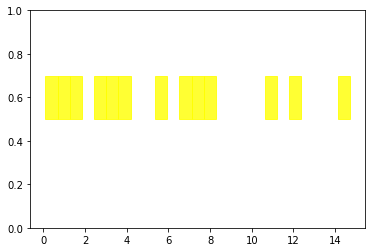

In [114]:
for irow in range(0,len(test1)):
    if ~np.isnan(test1['ATP'].iloc[irow]):
        if test1['ATP'].iloc[irow]==-1:
            colornow = 'red'
        elif test1['ATP'].iloc[irow]==0:
            colornow = 'yellow'
        elif test1['ATP'].iloc[irow]==1:
            colornow = 'green'
        plt.axvspan(test1['lbinedges'].iloc[irow], test1['rbinedges'].iloc[irow],
                    ymin=0.5, ymax=0.7, alpha=0.8, color=colornow)

In [81]:
avoidnow = test['bincenters'][test['ATP']==-1] 
tolnow = test['bincenters'][test['ATP']==0] 
prefnow = test['bincenters'][test['ATP']==1] 

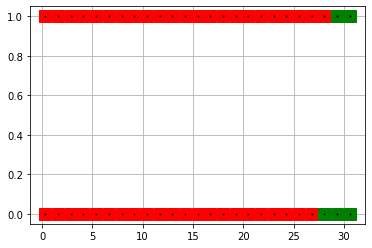

In [302]:
#plt.plot(avoidnow,np.zeros(len(avoidnow)),'s',markersize=12,color='red')
#plt.plot(avoidnow,np.zeros(len(avoidnow)),'o',markersize=1,color='black')
#plt.plot(tolnow,np.zeros(len(tolnow)),'s',markersize=12,color='yellow')
#plt.plot(tolnow,np.zeros(len(tolnow)),'o',markersize=1,color='black')
#plt.plot(prefnow,np.zeros(len(prefnow)),'s',markersize=12,color='green')
#plt.plot(prefnow,np.zeros(len(prefnow)),'o',markersize=1,color='black')
plt.axhspan(0, 30, ymin=0.1, ymax=0.9, alpha=0.5, color='red')

avoidnow = test1['bincenters'][test1['ATP']==-1] 
tolnow = test1['bincenters'][test1['ATP']==0] 
prefnow = test1['bincenters'][test1['ATP']==1] 
plt.plot(avoidnow,np.ones(len(avoidnow)),'s',markersize=12,color='red')
plt.plot(avoidnow,np.ones(len(avoidnow)),'o',markersize=1,color='black')
plt.plot(tolnow,np.ones(len(tolnow)),'s',markersize=12,color='yellow')
plt.plot(tolnow,np.ones(len(tolnow)),'o',markersize=1,color='black')
plt.plot(prefnow,np.ones(len(prefnow)),'s',markersize=12,color='green')
plt.plot(prefnow,np.ones(len(prefnow)),'o',markersize=1,color='black')
plt.grid('both')